In [1]:
import os
import torch
import random
import torch.nn as nn
from PIL import Image
from tqdm.auto import tqdm
from torch.optim import Adam
from torchinfo import summary
from torchvision import transforms
from torchvision.transforms import v2
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights, resnet18, efficientnet_b0, EfficientNet_B0_Weights

In [2]:
# import kagglehub

# # # Download latest version
# path = kagglehub.dataset_download("lakshaymiddha/crack-segmentation-dataset")

# print("Path to dataset files:", path)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class CrackDataset(Dataset):
    def __init__(self, paths):
        self.transform = v2.Compose(
            [
                v2.Resize(384),  # Use 384 for EfficientNet, whatever for resnet
                v2.PILToTensor(),
                v2.ToDtype(torch.float32, scale=True),
            ]
        )

        self.images = [Image.open(path).convert("RGB") for path in tqdm(paths)]

        self.targets = []
        for filename in paths:
            if "noncrack" in filename.lower():
                self.targets.append(0)
            else:
                self.targets.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(self.images[idx])
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        return img, target

## EfficientNet_V2_S

In [5]:
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

In [6]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [7]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 1)
)

## ResNet18

In [8]:
# model = resnet18()
# for param in model.parameters():
#     param.requires_grad = False

In [9]:
# model.fc = nn.Linear(512, 1)

## Training

In [10]:
model.to(device);

In [11]:
summary(model, input_size=(16, 3, 384, 384))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [16, 1]                   --
├─Sequential: 1-1                                       [16, 1280, 12, 12]        --
│    └─Conv2dNormActivation: 2-1                        [16, 32, 192, 192]        --
│    │    └─Conv2d: 3-1                                 [16, 32, 192, 192]        (864)
│    │    └─BatchNorm2d: 3-2                            [16, 32, 192, 192]        (64)
│    │    └─SiLU: 3-3                                   [16, 32, 192, 192]        --
│    └─Sequential: 2-2                                  [16, 16, 192, 192]        --
│    │    └─MBConv: 3-4                                 [16, 16, 192, 192]        (1,448)
│    └─Sequential: 2-3                                  [16, 24, 96, 96]          --
│    │    └─MBConv: 3-5                                 [16, 24, 96, 96]          (6,004)
│    │    └─MBConv: 3-6                      

In [12]:
def train_step(model, dataloader, optimizer, scheduler, loss_fn, scaler, device):
    model.train()

    total_loss = 0
    correct = 0
    total = 0
    true_pos = 0
    false_pos = 0
    false_neg = 0

    for batch, target in tqdm(dataloader):
        batch, target = batch.to(device), target.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda"):
            logits = model(batch)
            loss = loss_fn(logits.squeeze(), target.squeeze())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()

        # Convert logits to binary predictions
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).int()
        preds = preds.squeeze()

        correct += (preds == target).sum().item()
        total += target.numel()

        # Calculate precision/recall components
        true_pos += ((preds == 1) & (target == 1)).sum().item()
        false_pos += ((preds == 1) & (target == 0)).sum().item()
        false_neg += ((preds == 0) & (target == 1)).sum().item()

    accuracy = correct / total
    precision = true_pos / (true_pos + false_pos + 1e-8)
    recall = true_pos / (true_pos + false_neg + 1e-8)
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy, precision, recall


def valid_step(model, dataloader, loss_fn, device):
    avg_loss = 0
    avg_accuracy = 0
    avg_precision = 0
    avg_recall = 0
    model.eval()

    with torch.inference_mode():
        for batch, target in tqdm(dataloader):
            batch, target = batch.to(device), target.to(device)

            logits = model(batch)
            loss = loss_fn(logits.squeeze(), target.squeeze())
            avg_loss += loss.item()

            preds = torch.sigmoid(logits)
            preds = (preds > 0.5).int()
            preds = preds.squeeze()

            correct = (preds == target).sum().item()
            total = target.numel()

            true_pos = ((preds == 1) & (target == 1)).sum().item()
            false_pos = ((preds == 1) & (target == 0)).sum().item()
            false_neg = ((preds == 0) & (target == 1)).sum().item()

            accuracy = correct / total
            precision = true_pos / (true_pos + false_pos + 1e-8)
            recall = true_pos / (true_pos + false_neg + 1e-8)

            avg_accuracy += accuracy
            avg_precision += precision
            avg_recall += recall

    avg_loss /= len(dataloader)
    avg_accuracy /= len(dataloader)
    avg_precision /= len(dataloader)
    avg_recall /= len(dataloader)

    return avg_loss, avg_accuracy, avg_precision, avg_recall

In [13]:
def train(
    model,
    train_dl,
    valid_dl,
    optimizer,
    scheduler: OneCycleLR,
    loss_fn,
    epochs,
    start_checkpoint=None,
):
    os.makedirs("../tmp_model_checkpoints", exist_ok=True)
    counter = 0  # count epochs without printing training stats
    scaler = GradScaler("cuda")

    if start_checkpoint:
        start_epoch = start_checkpoint["epoch"] + 1
        best_acc = start_checkpoint["best_acc"]
        best_prec = start_checkpoint["best_prec"]
        best_rec = start_checkpoint["best_rec"]
        scaler.load_state_dict(start_checkpoint["scaler_state_dict"])
    else:
        start_epoch = 0
        best_acc = 0
        best_prec = 0
        best_rec = 0

    log_freq = (
        epochs - start_epoch
    ) // 1  # how often to print stats when no progress is made

    for epoch in range(start_epoch, epochs):
        counter += 1
        train_loss, train_acc, train_prec, train_rec = train_step(
            model, train_dl, optimizer, scheduler, loss_fn, scaler, device
        )

        valid_loss, valid_acc, valid_prec, valid_rec = valid_step(
            model, valid_dl, loss_fn, device
        )

        progress = False

        if valid_acc > best_acc:
            progress = True
            best_acc = valid_acc
            checkpoint = {
                "epoch": epoch,
                "best_acc": best_acc,
                "best_prec": best_prec,
                "best_rec": best_rec,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
            }
            torch.save(checkpoint, f"../tmp_model_checkpoints/best_accuracy.pth")

        if valid_prec > best_prec:
            progress = True
            best_prec = valid_prec
            ccheckpoint = {
                "epoch": epoch,
                "best_acc": best_acc,
                "best_prec": best_prec,
                "best_rec": best_rec,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
            }
            torch.save(checkpoint, f"../tmp_model_checkpoints/best_precision.pth")

        if valid_rec < best_rec:
            progress = True
            best_rec = valid_rec
            checkpoint = {
                "epoch": epoch,
                "best_acc": best_acc,
                "best_prec": best_prec,
                "best_rec": best_rec,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
            }
            torch.save(checkpoint, f"../tmp_model_checkpoints/best_recall.pth")

        if epoch == epochs - 1:
            checkpoint = {
                "epoch": epoch,
                "best_acc": best_acc,
                "best_prec": best_prec,
                "best_rec": best_rec,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
            }
            torch.save(checkpoint, f"../tmp_model_checkpoints/last.pth")

        if True or progress or counter >= log_freq:
            counter = 0
            print(
                f"Epoch: {epoch + 1} | "
                f"[train] loss: {train_loss:.4f} | "
                f"[valid] loss: {valid_loss:.4f} | "
                f"[valid] Accuracy: {valid_acc:.4f} | "
                f"[valid] Precision: {valid_prec:.4f} | "
                f"[valid] Recall: {valid_rec:.4f}"
            )

In [14]:
files = os.listdir("train/images/")
paths = [os.path.join("train/images/", filename) for filename in files if filename.lower().endswith(".jpg")]
random.shuffle(paths)
split_idx = int(0.8 * len(paths))
train_paths = paths[:split_idx]
valid_paths = paths[split_idx:]

files = os.listdir("test/images/")
test_paths = [os.path.join("test/images/", filename) for filename in files if filename.lower().endswith(".jpg")]

In [15]:
train_ds = CrackDataset(train_paths)
valid_ds = CrackDataset(valid_paths)
test_ds = CrackDataset(test_paths)

  0%|          | 0/7682 [00:00<?, ?it/s]

  0%|          | 0/1921 [00:00<?, ?it/s]

  0%|          | 0/1695 [00:00<?, ?it/s]

In [16]:
# Print dataset stats (num of 0/1)
from collections import Counter


def print_dataset_stats(ds, name):
    counts = Counter(ds.targets)
    print(f"{name} dataset - Non-crack: {counts[0]}, Crack: {counts[1]}")


print_dataset_stats(train_ds, "Train")
print_dataset_stats(valid_ds, "Valid")
print_dataset_stats(test_ds, "Test")

Train dataset - Non-crack: 964, Crack: 6718
Valid dataset - Non-crack: 235, Crack: 1686
Test dataset - Non-crack: 212, Crack: 1483


In [17]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=os.cpu_count()-1)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=False, num_workers=os.cpu_count()-1)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-2)
scheduler = OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_dl), epochs=10)

train(model, train_dl, valid_dl, optimizer, scheduler, loss_fn, 10)

  0%|          | 0/481 [00:02<?, ?it/s]

  0%|          | 0/121 [00:01<?, ?it/s]

Epoch: 1 | [train] loss: 0.1628 | [valid] loss: 0.4602 | [valid] Accuracy: 0.9742 | [valid] Precision: 0.9782 | [valid] Recall: 0.9754


  0%|          | 0/481 [00:02<?, ?it/s]

KeyboardInterrupt: 

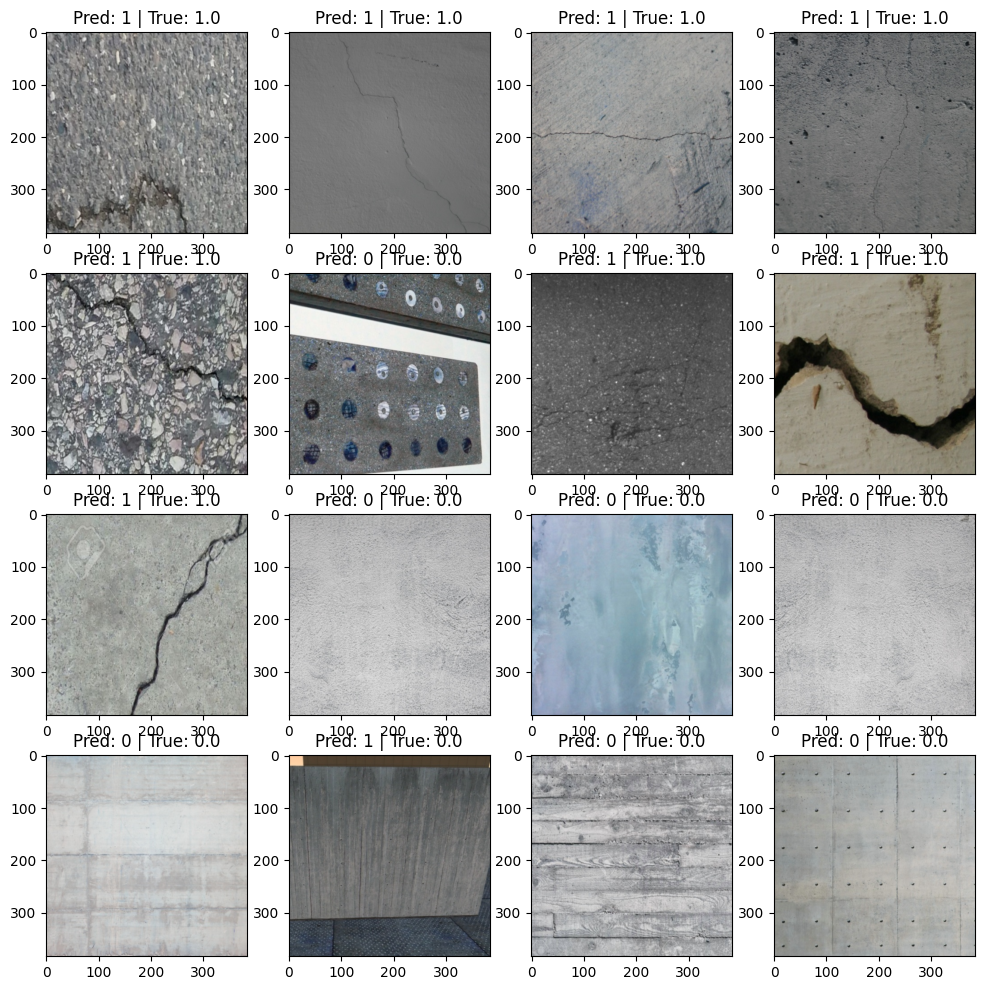

In [18]:
import matplotlib.pyplot as plt

# Show some predictions on test set (both 0 and 1)
test_dl = DataLoader(
    test_ds, batch_size=16, shuffle=True, num_workers=os.cpu_count() - 1
)

model.eval()

# collect examples
test_examples = []
n_0, n_1 = 0, 0
for batch, target in test_dl:
    for i in range(len(target)):
        if target[i].item() == 0 and n_0 < 8:
            test_examples.append((batch[i].unsqueeze(0), target[i].unsqueeze(0)))
            n_0 += 1
        elif target[i].item() == 1 and n_1 < 8:
            test_examples.append((batch[i].unsqueeze(0), target[i].unsqueeze(0)))
            n_1 += 1
    if n_0 >= 8 and n_1 >= 8:
        break

with torch.inference_mode():
    fig, ax = plt.subplots(4, 4, figsize=(12, 12))
    for i, (batch, target) in enumerate(test_examples):
        batch, target = batch.to(device), target.to(device)
        logits = model(batch)
        preds = torch.sigmoid(logits)
        preds = (preds > 0.5).int().squeeze()

        img = batch[0].cpu().permute(1, 2, 0).numpy()
        ax[i // 4, i % 4].imshow(img)
        ax[i // 4, i % 4].set_title(f"Pred: {preds.item()} | True: {target.item()}")